In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.scale import scale_factory

from dataloader import load_raw, create_datasets, create_dataloaders
from measures import quantile_loss, compute_intermittent_indicators, rho_risk

from gluonts.torch.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.torch.distributions import NegativeBinomialOutput, TweedieOutput
from gluonts.dataset.common import ListDataset
from lightning.pytorch.callbacks import EarlyStopping
from gluonts.evaluation import make_evaluation_predictions

In [3]:
dataset_name = "M5"
method = "DNNs_new"
likelihood = 'tw'

data_raw, data_info = load_raw(dataset_name, datasets_folder_path=os.path.join("..","data"))
adi, cv2 = compute_intermittent_indicators(data_raw, data_info['h'])
datasets = create_datasets(data_raw, data_info)

max_lag = {
    'carparts':44,
    'OnlineRetail':56,
    'Auto':16,
    'RAF':45,
    'M5':50
}
max_value = data_raw.dropna().values.max()

lags = np.arange(1,max_lag[dataset_name]) if dataset_name != "M5" else [1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,80,100,150]
lags = np.unique(np.sort(np.concatenate([lags, np.array([data_info['h']*data_info['w']])])))
quantiles = np.array([0.5, 0.8, 0.9, 0.95, 0.99])

In [4]:
def prepare_entry(x, i, scale=True):
    x.pop('feat_static_cat', None)
    x.pop('feat_dynamic_real', None)
    x.pop('item_id', None)
    x['target'] = np.array(x['target'])
    return x
    
ds_train = ListDataset([prepare_entry(x, i) for i, x in enumerate(datasets['train'])], freq=data_info['freq'])
ds_valid = ListDataset([prepare_entry(x, i) for i, x in enumerate(datasets['valid'])], freq=data_info['freq'])
ds_test = ListDataset([prepare_entry(x, i, scale=False) for i, x in enumerate(datasets['test'])], freq=data_info['freq'])

In [ ]:
if likelihood == "tw":
    distr_output = TweedieOutput()
elif likelihood == "nb":
    distr_output = NegativeBinomialOutput()

for lag in lags:
    print(lag)
    model_folder_name = method+"l" + str(lag) + "_" + likelihood + "__" + dataset_name
    model_folder_path = os.path.join('dnn-regression', model_folder_name)
    
    estimator = SimpleFeedForwardEstimator(
        scale=True,
        prediction_length=data_info["h"],
        context_length=lag,
        hidden_dimensions= [32, 32, 32, 32, 32],
        lr= 1e-4,
        weight_decay= 1e-8,
        distr_output=distr_output,
        batch_norm=False,
        batch_size=64,
        num_batches_per_epoch=50,
        trainer_kwargs={'accelerator':'cpu', 'max_epochs':1_000, 'enable_progress_bar': False, 'gradient_clip_val':1.0,
                        'callbacks': [EarlyStopping(monitor="val_loss", patience=20, verbose=True, mode="min")]},
    )
    
    predictor = estimator.train(training_data=ds_train, validation_data=ds_valid)
    
    forecast_it, ts_it = make_evaluation_predictions(dataset=ds_test, predictor=predictor, num_samples=400)
    forecasts, tss = list(forecast_it), list(ts_it)
    actuals = np.array([x[-data_info["h"]:].values.reshape(-1) for x in tss])
    quantile_forecasts = np.empty(shape=(len(datasets['test']), quantiles.size, data_info['h']))
    for i, f in enumerate(forecasts):
        try:
            for qi, q in enumerate(quantiles):
                quantile_forecasts[i,qi,:] = np.round(f.quantile(q))
        except:
            samples = f.to_sample_forecast(50000).samples
            quantile_forecasts[i,:,:] = np.round(np.quantile(samples, quantiles, axis=0))
            
    #quantile_forecasts[quantile_forecasts > max_value] = max_value
    
    if not os.path.exists(path=model_folder_path):
        os.makedirs(model_folder_path)
    if lag==1: np.save(os.path.join(model_folder_path,"actuals.npy"), actuals)
    np.save(os.path.join(model_folder_path,"qforecasts.npy"), quantile_forecasts)

In [5]:
subset="intermittent_and_lumpy"
if subset == "intermittent":
    filter, filter_label = np.logical_and(adi >= 1.32, cv2 < .49), "intermittent"
elif subset == "intermittent_and_lumpy":
    filter, filter_label = adi >= 1.32, "intermittent_and_lumpy"
elif subset == "all":
    filter, filter_label = np.tile(True, adi.size), "all"

In [6]:
tmp = np.empty(shape=(len(datasets['test']), len(datasets['valid'][0]['target']), quantiles.size))
for i in range(len(datasets['test'])):
    tmp[i, :] = np.round(np.quantile(datasets['valid'][i]['target'], q=quantiles))
res_base_scale_tmp = []
for i in range(len(datasets['test'])):
    res_base_scale_tmp.append(quantile_loss(
        np.array(datasets['valid'][i]['target']).reshape(1,-1), 
        tmp[i].reshape(1,tmp[i].shape[0],tmp[i].shape[1]), 
        quantiles, avg=False))
res_base_scale = {}
for q in ['QL50','QL80','QL90','QL95','QL99']:
    res_base_scale[q] = np.mean(np.vstack([res_base_scale_tmp[i][q] for i in range(len(datasets['test']))]), axis=1)

scale = True
fscale = lambda x, q: x / res_base_scale[q][filter, np.newaxis] if scale else x

path = os.path.join("dnn-regression")
names = [folder for folder in os.listdir(path) 
                  if os.path.isdir(os.path.join(path, folder))]
names_sub = [x for x in names if (x.split('__')[1] == dataset_name) and (x.split('__')[0].split('l')[0] == method)]
M = {"tw":{}, "nb":{}}
actuals = np.load(os.path.join(path, method+'l1_nb__'+dataset_name, "actuals.npy"))[filter]
for n in names_sub:
    quantile_forecasts = np.load(os.path.join(path, n, "qforecasts.npy"))[filter]
    l, distr = n.split('l')[1].split('__')[0].split('_')
    M[distr][int(l)] = quantile_loss(actuals, np.transpose(quantile_forecasts, (0,2,1)), quantiles, avg=False)

for distr in M.keys():  
    M[distr] = {key: M[distr][key] for key in sorted(M[distr].keys())}

for distr in M.keys():
    for k in M[distr].keys():
        for l in M[distr][k].keys():
            M[distr][k][l] = fscale(M[distr][k][l], l)

# Local methods
baseline_path = os.path.join(os.path.expanduser("~/switchdrive"), "iTS", "trained_models_baselines")
baselines_name = [folder for folder in os.listdir(baseline_path) 
                  if os.path.isdir(os.path.join(baseline_path, folder)) and os.path.exists(os.path.join(baseline_path, folder, 'metrics.json'))]
baselines_name_sub = [x for x in baselines_name if x.split('__')[1] == dataset_name]

iETS_actuals = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["iETS" in x for x in baselines_name_sub]][0], "actuals.npy"))[filter]
iETS_quantile_forecasts = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["iETS" in x for x in baselines_name_sub]][0], "qforecasts.npy"))[filter]
iETS = quantile_loss(iETS_actuals, iETS_quantile_forecasts, quantiles, avg=False)
EmpQ_actuals = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["EmpQ" in x for x in baselines_name_sub]][0], "actuals.npy"))[filter]
EmpQ_quantile_forecasts = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["EmpQ" in x for x in baselines_name_sub]][0], "qforecasts.npy"))[filter]
EmpQ = quantile_loss(EmpQ_actuals, EmpQ_quantile_forecasts, quantiles, avg=False)
Tweedie_quantile_forecasts = np.load(os.path.join(os.path.expanduser("~/switchdrive"), "iTS", "trained_models_baselines", f"TweedieGP/{dataset_name}/qforecasts.npy"))[filter]
Tweedie = quantile_loss(iETS_actuals, Tweedie_quantile_forecasts, quantiles, avg=False)

assert iETS.keys() == EmpQ.keys() == Tweedie.keys()
for k in iETS.keys():
    iETS[k] = fscale(iETS[k],k)
    EmpQ[k] = fscale(EmpQ[k],k)
    Tweedie[k] = fscale(Tweedie[k],k)

In [7]:
import pickle as pkl
for distr in M.keys():
    pkl.dump(M[distr], open(os.path.join('cache_global', method+'_'+distr+'_'+dataset_name+".pkl"), 'wb'))
pkl.dump(iETS, open(os.path.join('cache_global', "iETS"+'_'+dataset_name+".pkl"), 'wb'))
pkl.dump(EmpQ, open(os.path.join('cache_global', "EmpQ"+'_'+dataset_name+".pkl"), 'wb'))
pkl.dump(Tweedie, open(os.path.join('cache_global', "Tweedie"+'_'+dataset_name+".pkl"), 'wb'))

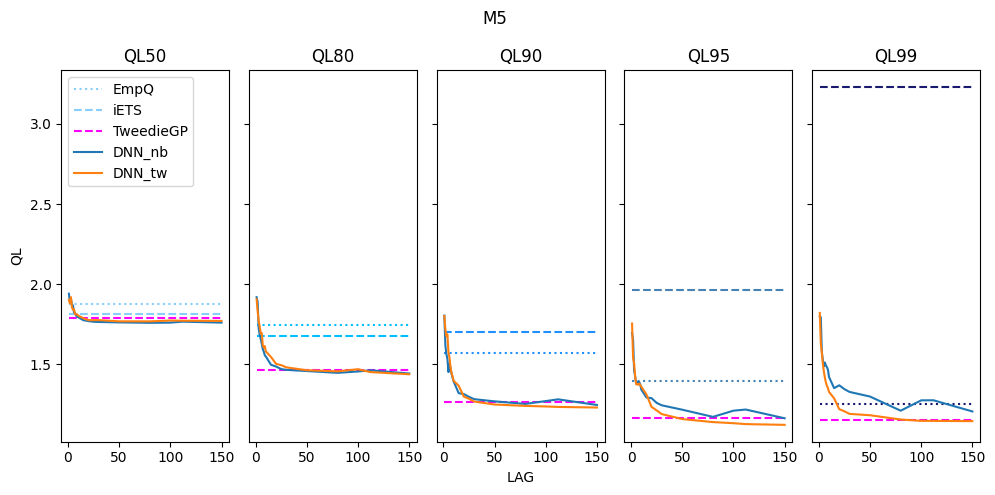

In [8]:
f = np.mean
d = ['nb', 'tw']

Q = list(M[d[0]][lags[0]].keys())
fig, axs = plt.subplots(1,len(Q), figsize=(10,5), sharey=True)
colors = ['#87CEFA','#00BFFF','#1E90FF','#4682B4','#191970']
for ax, c, q_ in zip(axs, colors, Q):
    ax.hlines(y=f(EmpQ[q_]), xmin=1, xmax=lags[-1], color=c, linestyle=':', label="EmpQ")
    ax.hlines(y=f(iETS[q_]), xmin=1, xmax=lags[-1], color=c, linestyle='--', label="iETS")
    ax.hlines(y=f(Tweedie[q_]), xmin=1, xmax=lags[-1], color="magenta", linestyle='--', label="TweedieGP")
    for distr in d:
        tmp = np.array([np.nanmean(M[distr][l][q_]) for l in lags])
        ax.plot(lags, tmp, label="DNN_"+distr, )
    ax.set_title(q_)
axs[2].set_xlabel('LAG')
axs[0].set_ylabel('QL')
axs[0].legend(loc="upper left")
plt.suptitle(dataset_name)
plt.tight_layout()
plt.show()